In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle

## load the IATA data
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    
    G = pickle.load(f)

In [3]:
from gcmap import GCMapper, Gradient
## make G undirected
G_undirect = G.to_undirected(reciprocal=True)
source_lon, source_lat, destination_lon, destination_lat, nb_flights = [], [], [], [], []
edges = G_undirect.edges(data=True)
for u, v, data in edges:
    if u != v:
        source_lon.append(IATA[u]['longitude'])
        source_lat.append(IATA[u]['latitude'])
        destination_lon.append(IATA[v]['longitude'])
        destination_lat.append(IATA[v]['latitude'])
        nb_flights.append(data['weight'])
        
grad = Gradient(((0, 0, 0, 0), (0.5, 204, 0, 153), (1, 255, 204, 230)))
gcm = GCMapper(cols=grad, height=2000, width=4000)
gcm.set_data(source_lon, source_lat, destination_lon, destination_lat, nb_flights)
img = gcm.draw()
img.show()
img.save('images/flightmap.png')

C:\Users\Andba\AppData\Local\Temp\ipykernel_9252\3506698422.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Andba\AppData\Local\Temp\ipykernel_9252\3506698422.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  m.scatter(x, y, c=color, s=sizes)


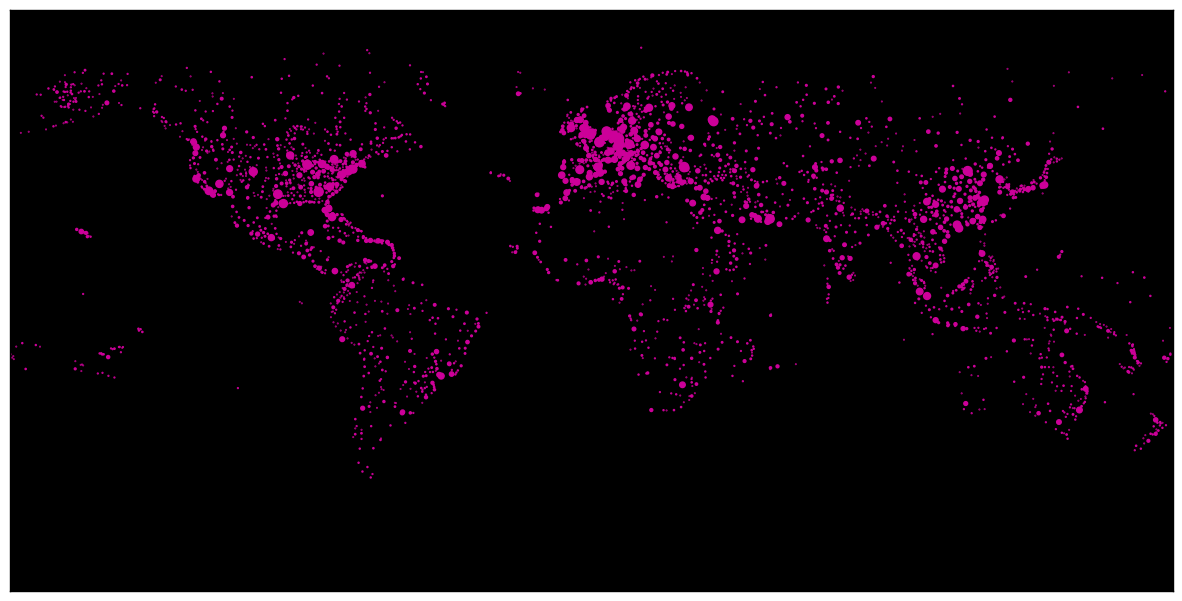

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import PowerNorm, LogNorm
from matplotlib.colorbar import ColorbarBase
from tqdm import tqdm

## create a basemap
fig, ax = plt.subplots(figsize=(15, 10))
resolution = "c"
m = Basemap(lon_0=0, resolution=resolution)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color="lightgrey", linewidth=0.3)

continent_to_color = {'Africa': 'red', 'Asia': 'blue', 'Europe': 'green', 'North America': 'yellow', 'Oceania': 'purple', 'South America': 'orange'}

## plot the nodes
lons = [IATA[node]['longitude'] for node in G_undirect.nodes()]
lats = [IATA[node]['latitude'] for node in G_undirect.nodes()]
sizes = [0.2 * G_undirect.degree(node) for node in G_undirect.nodes()]
colors = [continent_to_color[IATA[node]['continent']] for node in G_undirect.nodes()]
x, y = m(lons, lats)
color = (204 / 255, 0 / 255, 153 / 255)
m.scatter(x, y, c=color, s=sizes)
plt.savefig('images/flightmap_nodes.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [5]:
import netwulf as nw
nw.visualize(G)

(None, None)

Nodes with the highest degree:  [('FRA', 477), ('CDG', 470), ('AMS', 463), ('IST', 455), ('ATL', 433), ('ORD', 409), ('PEK', 408), ('MUC', 380), ('DME', 376), ('DFW', 372)]


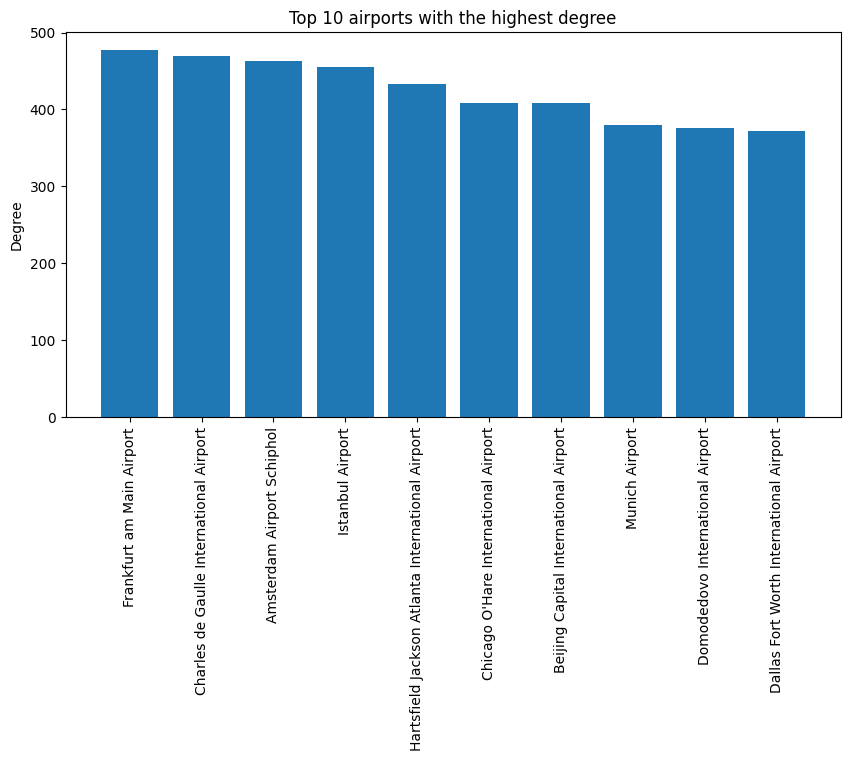

Edges with the highest weight:  [(('ORD', 'ATL'), 20), (('ATL', 'ORD'), 19), (('HKT', 'BKK'), 13), (('ORD', 'MSY'), 13), (('LHR', 'JFK'), 12), (('AUH', 'MCT'), 12), (('HKG', 'BKK'), 12), (('CAN', 'HGH'), 12), (('MIA', 'ATL'), 12), (('ATL', 'MIA'), 12)]


In [6]:
## find nodes with the highest degree
## make a bar plot of the top 10
## on the x-axis, put the airport city name
## on the y-axis, put the degree of the airport
degrees = dict(G.degree())
sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Nodes with the highest degree: ", sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10, 5))
plt.bar([G.nodes[k]["name"] for k, v in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]],
        [v for k, v in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]])
plt.xticks(rotation=90)
plt.ylabel('Degree')
plt.title('Top 10 airports with the highest degree')
plt.savefig('images/top10_airports_degree.png', dpi=300, bbox_inches='tight')
plt.show()



## find the edges with the highest weight
weights = nx.get_edge_attributes(G, 'weight')
sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10]
print("Edges with the highest weight: ", sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

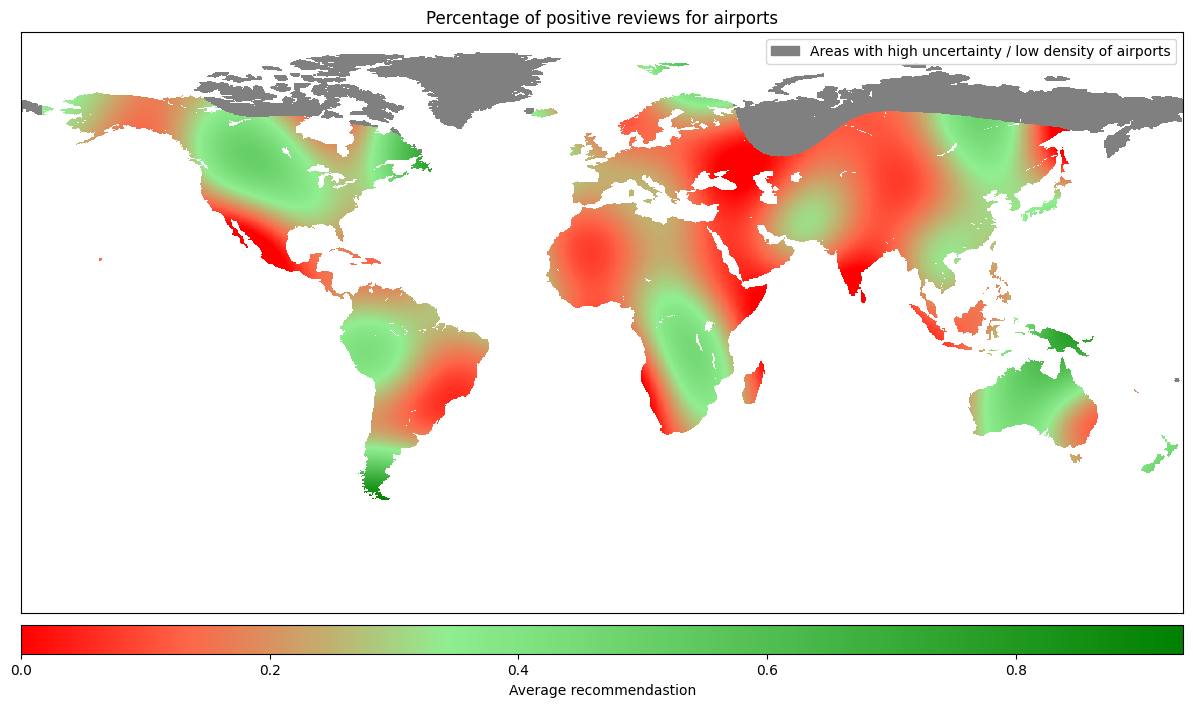

In [7]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
import matplotlib.patches as mpatches


## make a grey cmap, that always returns grey
cmap_grey = LinearSegmentedColormap.from_list(
    "grey", 
    [(0, "grey"), (1, "grey")]
)

airports = pd.read_csv("data/airports_cleaned.csv", index_col=0)
airports = airports.dropna(subset=["average_recommendation"])
X = airports[["latitude", "longitude"]].to_numpy()
y = airports["average_recommendation"].to_numpy()

kernel = RBF(length_scale=15, length_scale_bounds="fixed")
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)
model.fit(X, y)

resolution = 1000
lats, lons = X[:, 0], X[:, 1]
min_lats, max_lats = -90, 90
min_lons, max_lons = -180, 180

lats = np.linspace(min_lats, max_lats, resolution)
lons = np.linspace(min_lons, max_lons, resolution)
lats, lons = np.meshgrid(lats, lons)
Xmesh = np.vstack([lats.ravel(), lons.ravel()]).T
ymesh, uncertainty = model.predict(Xmesh, return_std=True)
uncertainty = uncertainty.reshape((resolution, resolution))
ymesh = ymesh.reshape((resolution, resolution))
ymesh = np.clip(ymesh, 0, 1)

## get 25th and 75th percentile
percentilelow = np.percentile(ymesh.flatten(), 25)
percentilehigh = np.percentile(ymesh.flatten(), 80)

## make a colormap that is red for low values and green for high values of ymesh
cmap = LinearSegmentedColormap.from_list(
    "custom", 
    [(0, "red"), (percentilelow, "tomato"), (percentilehigh, "lightgreen"), (1, "green")]
) 

def is_water(lat, lon):
    return not m.is_land(lon, lat)

try: 
    ywater = np.load(f"data/ywater{resolution}.npy")
except:
    ywater = np.zeros_like(ymesh)
    for i in tqdm(range(ymesh.shape[0])):
        for j in range(ymesh.shape[1]):
            if is_water(lats[i, j], lons[i, j]):
                ywater[i, j] = 1
    np.save(f"data/ywater{resolution}.npy", ywater)
            
watermasked = np.ma.masked_where(ywater == 1, ymesh)
max_uncertainty = 0.15
uncertain_or_water_masked = np.ma.masked_where((uncertainty < max_uncertainty) | (ywater == 1), np.ones_like(ymesh))

fig, ax = plt.subplots(figsize=(15, 10))
m = Basemap(lon_0=0)
m.pcolormesh(lons, lats, watermasked, cmap=cmap, shading='auto')
m.colorbar(location="bottom", label="Average recommendastion")
m.pcolor(lons, lats, uncertain_or_water_masked, cmap=cmap_grey)
## make a legend for the uncertainty
grey_patch = mpatches.Patch(color='grey', label='Areas with high uncertainty / low density of airports')
plt.legend(handles=[grey_patch])
plt.title("Percentage of positive reviews for airports")
plt.savefig('images/average_recommendation.png', dpi=300, bbox_inches='tight')